In [2]:

import dkistpkg_ct as DKISTanalysis
import numpy as np
import matplotlib.pyplot as plt
import tol_colors
import os
from astropy.io import fits
from datetime import time
import matplotlib.patches as patches

def rebin_image(arr, new_shape):
    """
    Rebins a 2D array (image) to a new shape by averaging pixel values.

    Parameters:
    arr (numpy.ndarray): The original 2D image array.
    new_shape (tuple): The desired new shape (rows, columns).
                       Each dimension of new_shape must be a factor of
                       the corresponding dimension in arr.shape.

    Returns:
    numpy.ndarray: The binned 2D array.
    """
    if not (arr.shape[0] % new_shape[0] == 0 and arr.shape[1] % new_shape[1] == 0):
        raise ValueError("New shape dimensions must be factors of original shape dimensions.")

    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

muted = DKISTanalysis.color_muted2()

l=0
CUT=2.2 # cutoff for mask-making
binning = 0 # to bin or not to bin?
diff = 0 # to diff or not to diff
if binning == 1:
    bin_x = 7 # this bins the VBI pixels to largest ViSP spatial scale (in scan dir), plus 1 for "safety"
    bin_y = 7
else:
    bin_x = 1 #initialize this parameter - will change if binning selected, below
    bin_y = 1 #initialize this parameter - will change if binning selected, below

# limits for flare region (defined by raw image)
xlow = 1600
xhigh = 2300
ylow = 900
yhigh = 2700

caII_low = 570
caII_high = 730
hep_low = 750
hep_high = 900

#define start and end times for series
starttime = 200
endtime = 450

# use destretched (0) or pre-destretched (1)?
stretched = 0

fr=21

#specific to this save
start = 57
nstep = 91
fullframenum = 1 #1 is the good seeing frame in visp data

#VBI directory
path_vbi = '/Volumes/VBI_External/pid_2_11/'
folder1_vbi = 'AKDKX'
#folder2_vbi = 'BYMOL'
dir_list2_vbi = DKISTanalysis.pathdef(path_vbi,folder1_vbi)

#destretched dataset
filename = ['/Users/coletamburri/Desktop/DKIST_Code/VBI_Destretching/AKDKX/'+
                'postdestretch_dataCubeFlareImpulsivePhase.fits'][0]

visp_file = '/Users/coletamburri/Desktop/11_Aug_2024_Cclass_Flare/Processed_ViSP_VBI_11Aug2024/ViSP_coalign_result_11Aug_Cclass'

file = '/Users/coletamburri/Desktop/11_Aug_2024_Cclass_Flare/Processed_ViSP_VBI_11Aug2024/ViSP_spectra_processed_11Aug24_CaII.npz'





In [3]:
timesvbi=[]
for i in range(len(dir_list2_vbi)):
    timesvbi.append(time(int(dir_list2_vbi[i][15:17]),
                      int(dir_list2_vbi[i][18:20]),
                      int(dir_list2_vbi[i][21:23])))
    
timesvbi = timesvbi[200:450]

#another time array
string = timesvbi[0].strftime("%H:%M:%S")
strtime =[]
for i in range(len(timesvbi)):
    strtime.append(timesvbi[i].strftime("%H:%M:%S"))

In [5]:

#optional - processing just from the files on HD (raw, not destretched)
if stretched == 1:
    vbi_X, vbi_Y, hdul1_vbi, dat0_vbi = DKISTanalysis.vbi_process(path_vbi,
                                                                  folder1_vbi)
    #just pixels
    vbix0 = np.arange(4096)
    vbiy0 = np.arange(4096)
    vbiX0,vbiY0= np.meshgrid(vbix0,vbiy0)
else:
    vbi_DS = fits.open(filename)

vbi_DSimgs = vbi_DS[0].data

arr = vbi_DSimgs

if binning == 1:
    new_height = vbi_DSimgs.shape[1] // bin_y
    new_width = vbi_DSimgs.shape[2] // bin_x
    
    binned = np.zeros((250,new_height,new_width))
    
    for i in range(250):
        binned[i,:,:] = rebin_image(vbi_DSimgs[i,:,:], (new_height,new_width))
    
    arr = binned



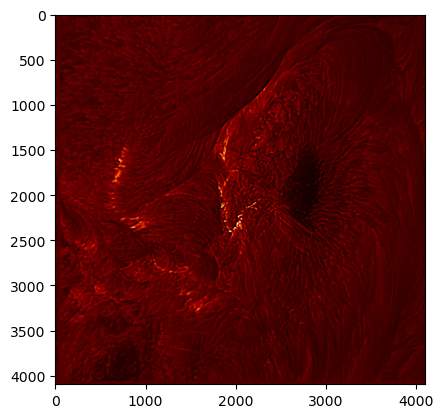

In [34]:
fig,ax=plt.subplots();
choice = arr[85,:,:]
normalized = (choice-choice.min()) /(choice.max() -choice.min())
ax.imshow(normalized,cmap='sdoaia304',vmin=0.1,vmax=0.7)

In [6]:

# create cumulative mask
mask = np.zeros(np.shape(arr))
timing = np.zeros(np.shape(arr)[1:3])

for i in range(100):
    l+=1
    if i>0:
        mask[i,:,:]=mask[i-1,:,:]
    maskvals = np.nonzero((arr[i,:,:]>CUT*np.median(arr[i,:,:])))
    for j in range(np.shape(maskvals)[1]):
        mask[i,maskvals[0][j],maskvals[1][j]] += 1
        #logic for timing array
        if timing[maskvals[0][j],maskvals[1][j]]==0:
            timing[maskvals[0][j],maskvals[1][j]]=l

#create timing series
for i in range(np.shape(timing)[0]):
    for j in range(np.shape(timing)[1]):
        if timing[i,j]==0:
            timing[i,j]='NaN'
            
#indices for light curves are in last cumulative mask
i_vals = []
j_vals = []

final_mask = mask[99,:,:]

for i in range(np.shape(final_mask)[0]):
    for j in range(np.shape(final_mask)[1]):
        if final_mask[i,j] > 0.0 and j>xlow/bin_x and j<xhigh/bin_x and i>ylow/bin_x and i<yhigh/bin_x:
            i_vals.append(i)
            j_vals.append(j)
            
# make light curve
lc=[]

for i in range(250):
    lc.append(np.sum(arr[i,int(ylow/bin_y):int(yhigh/bin_y),int(xlow/bin_x):int(xhigh/bin_x)]))

# cumulative mask movie
cumul_mask = np.zeros([100,np.shape(timing)[0],np.shape(timing)[1]])

for i in range(1,99):
    inds = np.where(timing==int(i))
    arrsamp = np.zeros(np.shape(timing))
    for j in range(np.shape(inds)[1]):
        arrsamp[inds[0][j],inds[1][j]]=timing[inds[0][j],inds[1][j]]
    cumul_mask[i,:,:]=cumul_mask[i-1,:,:]+arrsamp
    
cumul_mask[cumul_mask == 0] = np.nan

#instantaneous mask (new pixels)
inst_mask = np.zeros([100,np.shape(timing)[0],np.shape(timing)[1]])

for i in range(1,99):
    inds = np.where(timing==int(i))
    arrsamp = np.zeros(np.shape(timing))
    for j in range(np.shape(inds)[1]):
        arrsamp[inds[0][j],inds[1][j]]=1.0
    inst_mask[i,:,:]=arrsamp

inst_mask[inst_mask == 0] = np.nan

#instantaneous masks (all currently-lit pixels)
inst_mask_all = np.zeros([100,np.shape(timing)[0],np.shape(timing)[1]])

for i in range(1,99):
    mask = np.zeros(np.shape(timing))
    maskvals = np.nonzero((arr[i,:,:]>CUT*np.median(arr[i,:,:])))
    for j in range(np.shape(maskvals)[1]):
        mask[maskvals[0][j],maskvals[1][j]] += 1
    inst_mask_all[i,:,:]=mask

inst_mask_all[inst_mask_all == 0] = np.nan


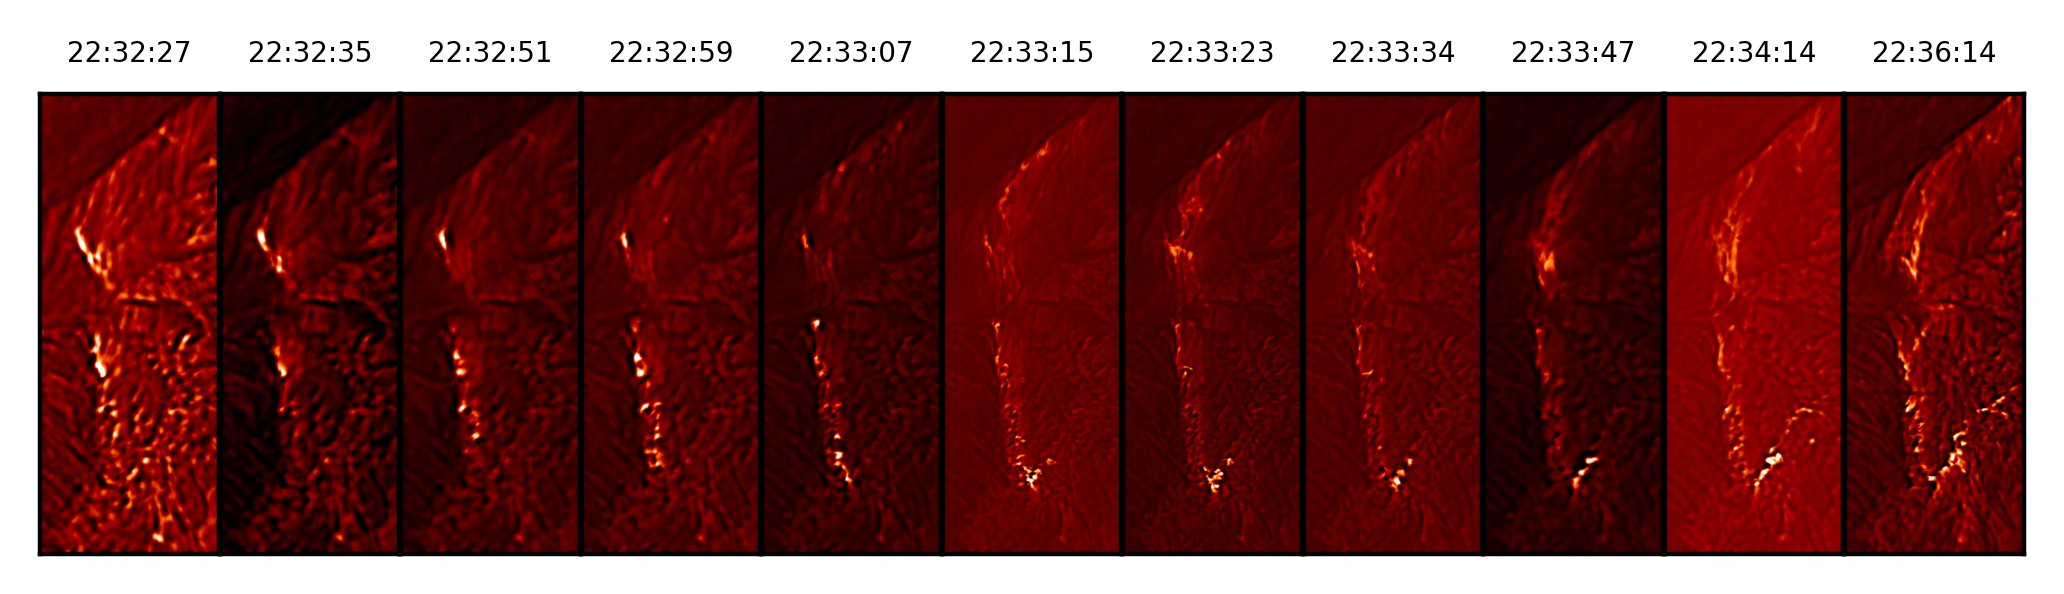

In [35]:
slices=[0,3,9,12,15,18,21,25,30,40,85]
fig,ax=plt.subplots(1,len(slices),dpi=400)

for i in range(len(slices)):
    choice = arr[slices[i],ylow:yhigh,xlow:xhigh]
    normalized = (choice-choice.min()) /(choice.max() -choice.min())
    ax.flatten()[i].imshow(normalized,cmap='sdoaia304',vmin=0.1,vmax=0.7)
    ax.flatten()[i].set_xticks([])
    ax.flatten()[i].set_yticks([])
    ax.flatten()[i].set_title(str(timesvbi[slices[i]]),fontsize=5)
    fig.subplots_adjust(wspace=0.01)

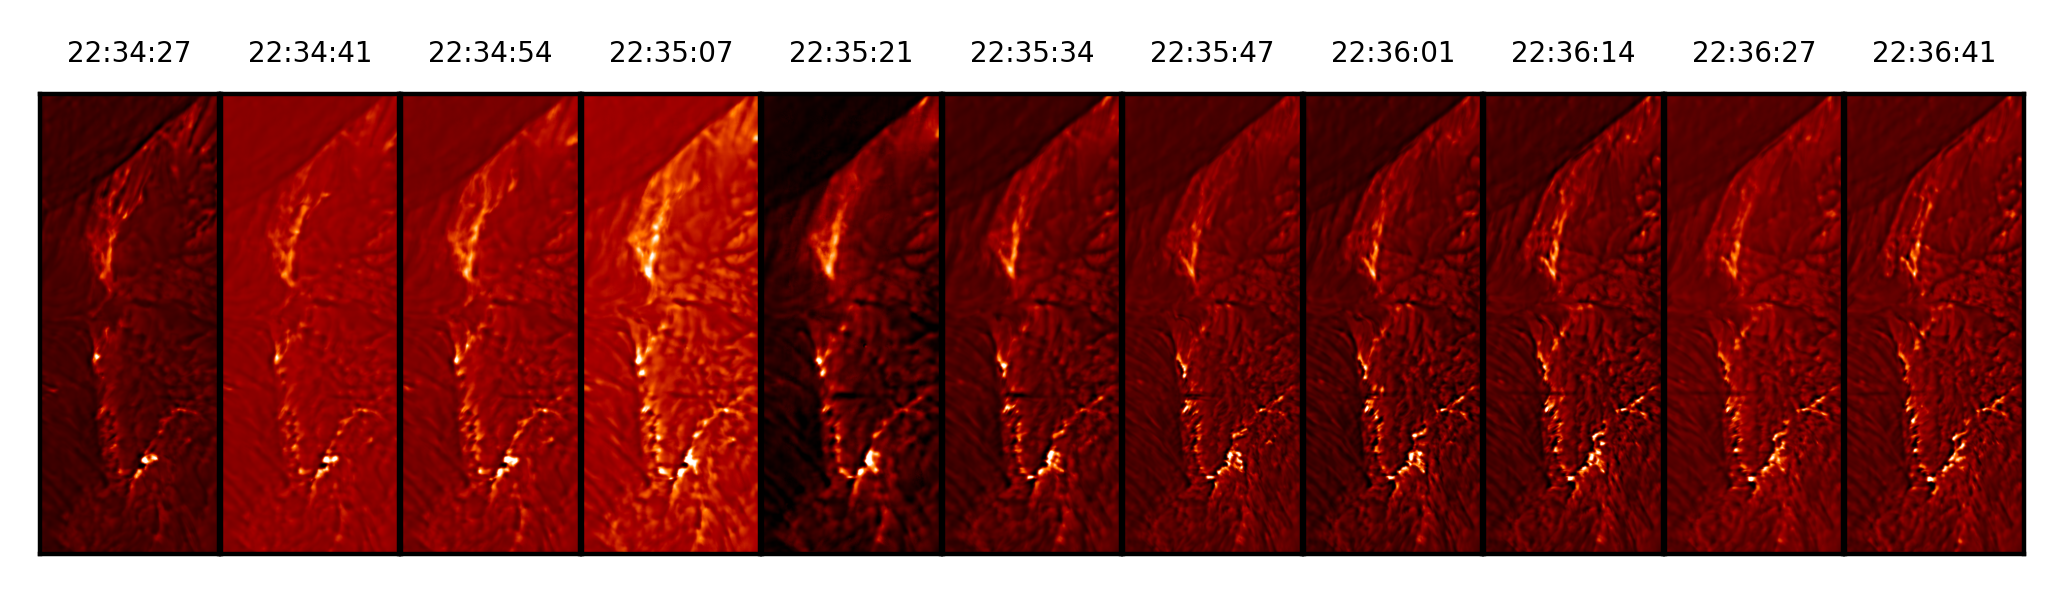

In [29]:
slices=[45,50,55,60,65,70,75,80,85,90,95]
fig,ax=plt.subplots(1,len(slices),dpi=400)

for i in range(len(slices)):
    choice = arr[slices[i],ylow:yhigh,xlow:xhigh]
    normalized = (choice-choice.min()) /(choice.max() -choice.min())
    ax.flatten()[i].imshow(normalized,cmap='sdoaia304',vmin=0.1,vmax=0.7)
    ax.flatten()[i].set_xticks([])
    ax.flatten()[i].set_yticks([])
    ax.flatten()[i].set_title(str(timesvbi[slices[i]]),fontsize=5)
    fig.subplots_adjust(wspace=0.01)

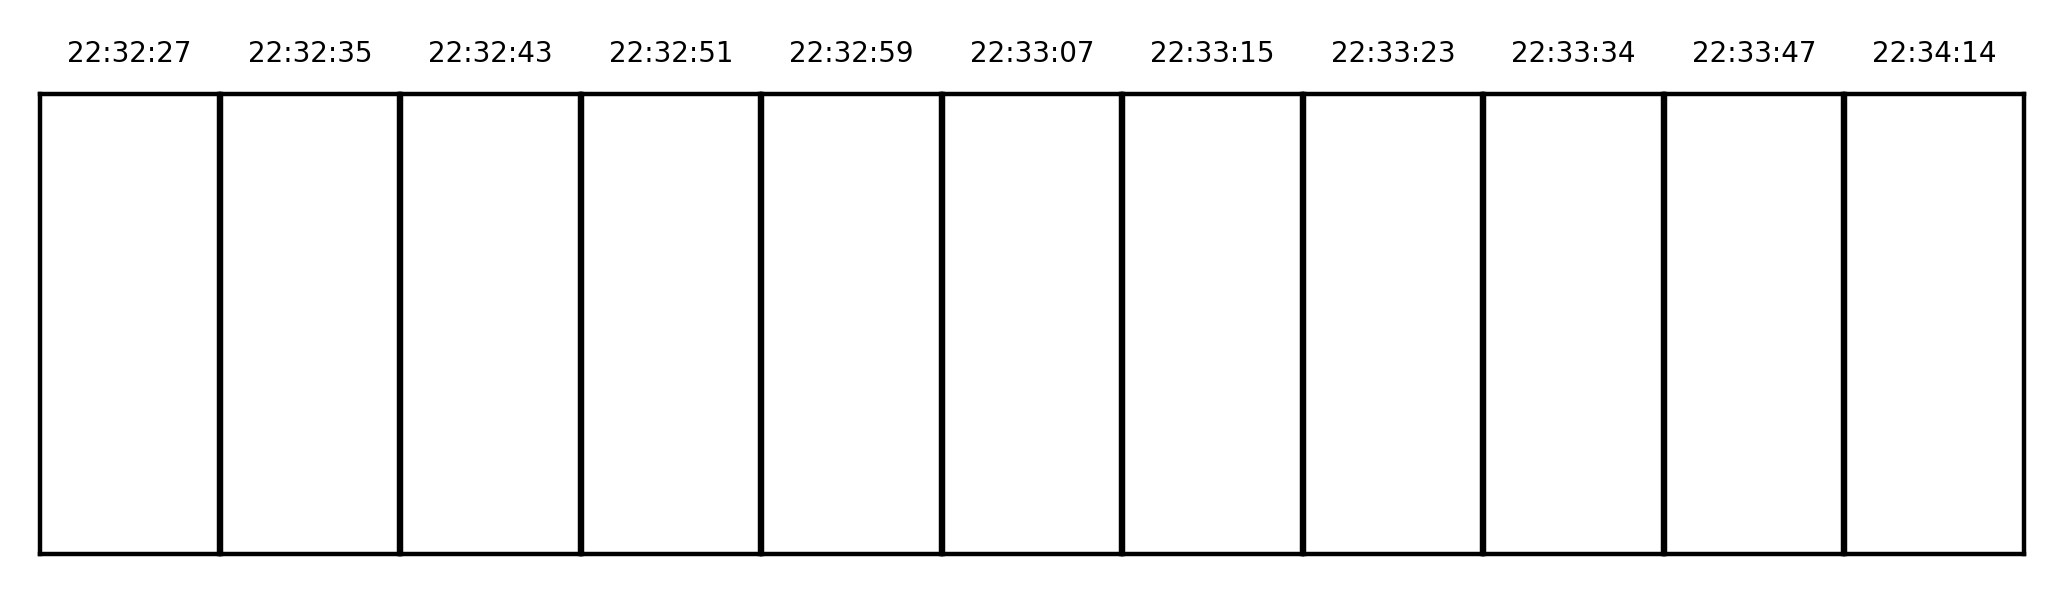

In [30]:
slices=[0,3,6,9,12,15,18,21,25,30,40]
fig,ax=plt.subplots(1,len(slices),dpi=400)

for i in range(len(slices)):
    choice = inst_mask[slices[i],ylow:yhigh,xlow:xhigh]
    normalized = (choice-choice.min()) /(choice.max() -choice.min())
    ax.flatten()[i].imshow(normalized,cmap='hot',vmin=0.1,vmax=0.9)
    ax.flatten()[i].set_xticks([])
    ax.flatten()[i].set_yticks([])
    ax.flatten()[i].set_title(str(timesvbi[slices[i]]),fontsize=5)
    fig.subplots_adjust(wspace=0.01)

In [33]:
cumul_mask

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

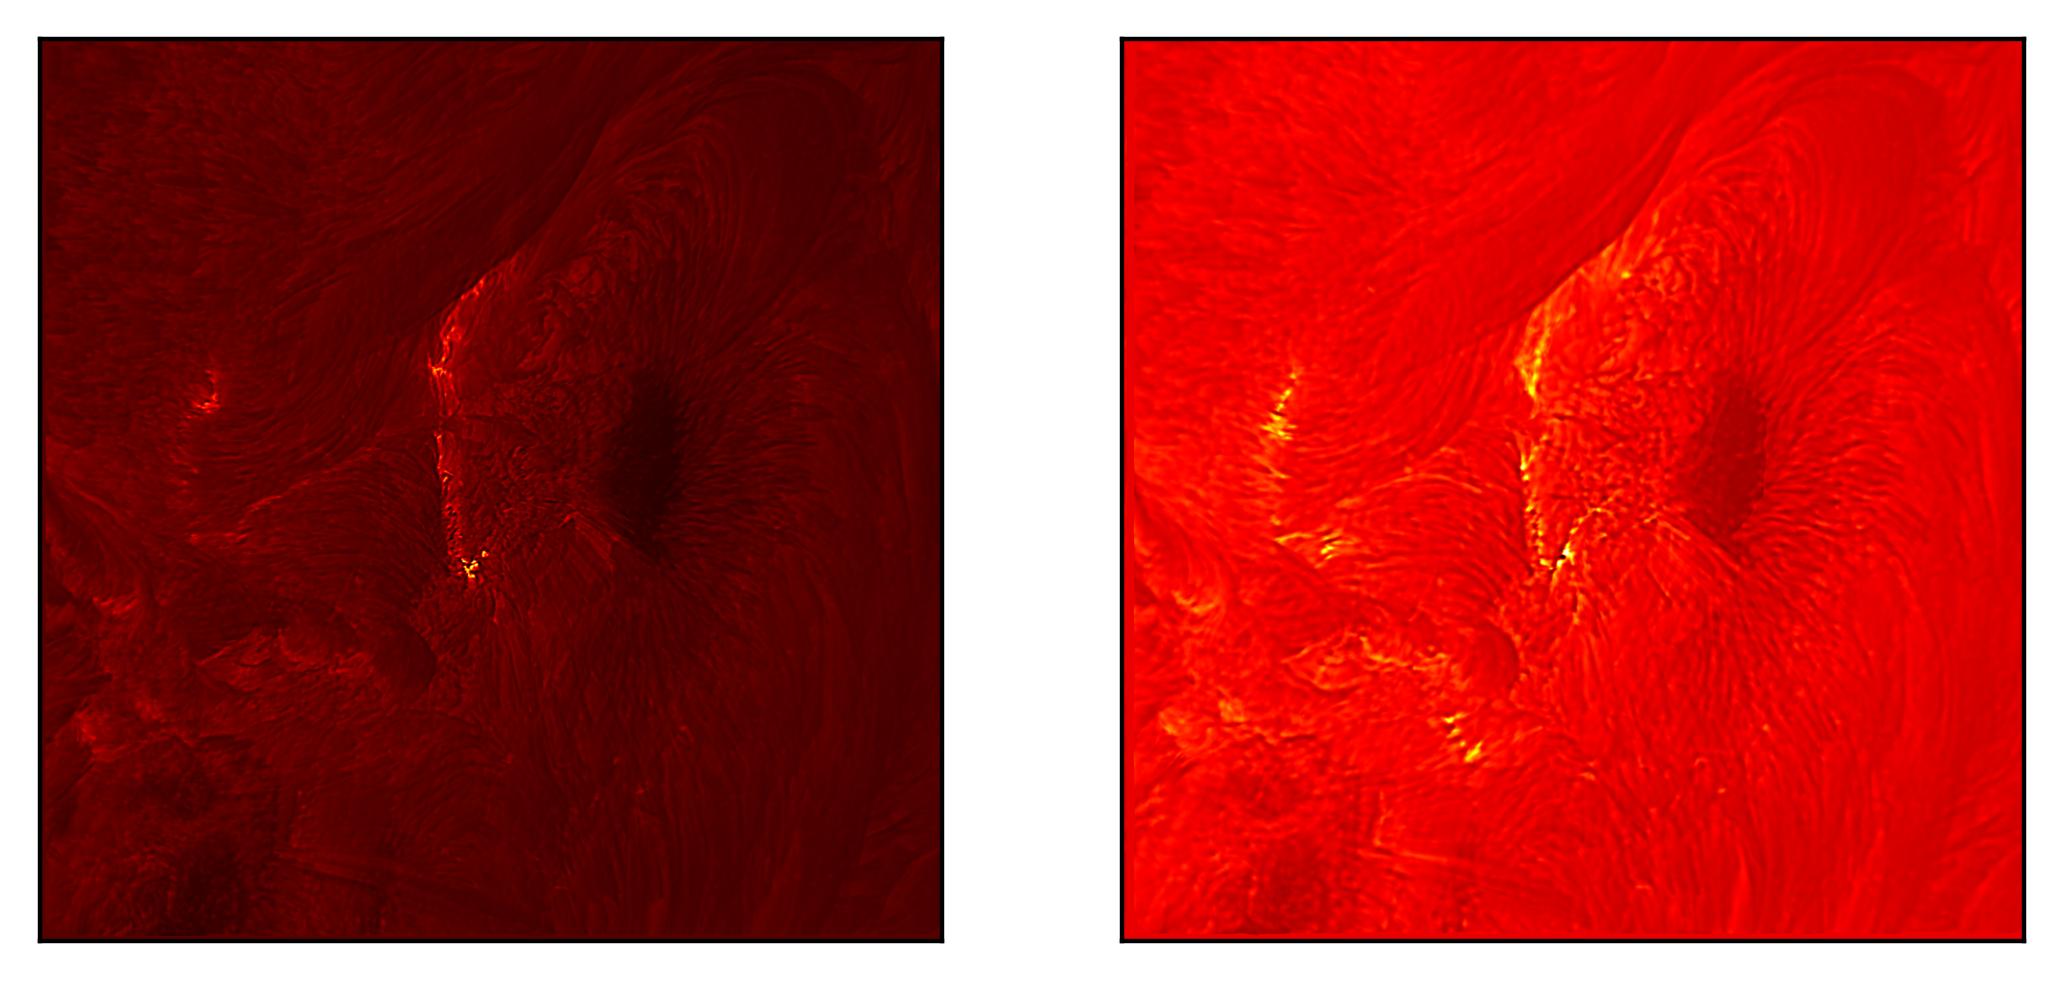

In [36]:
slices=[20,60]
fig,ax=plt.subplots(1,len(slices),dpi=400)

for i in range(len(slices)):
    choice = arr[slices[i],:,:]
    normalized = (choice-choice.min()) /(choice.max() -choice.min())
    ax.flatten()[i].imshow(normalized,cmap='hot',vmin=0.1,vmax=0.9)
    ax.flatten()[i].set_xticks([])
    ax.flatten()[i].set_yticks([])

In [37]:
timesvbi[60]

datetime.time(22, 35, 7)

In [ ]:
#fig,[(ax,ax1,ax2),(ax3,ax4,ax5)]=plt.subplots(2,3,dpi=200)
fig,[ax3,ax4,ax5]=plt.subplots(1,3,dpi=200)
ax3.imshow(arr[fr,ylow:yhigh,xlow:xhigh],cmap='hot')
ax4.imshow(inst_mask[fr,ylow:yhigh,xlow:xhigh],cmap=tol_colors.tol_cmap(colormap='rainbow_PuRd'), vmin=0, vmax=40)
img = ax5.imshow(cumul_mask[fr,ylow:yhigh,xlow:xhigh],cmap=tol_colors.tol_cmap(colormap='rainbow_PuRd'), vmin=0, vmax=40)
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])
ax5.set_xticks([])
ax5.set_yticks([])

cbar = fig.colorbar(img,ticks=[0,10,20,30,40])
cbar.ax.set_yticklabels([str(timesvbi[0]),str(timesvbi[10]),str(timesvbi[20]),str(timesvbi[30]),str(timesvbi[40])])

## Add the patch to the Axes
# ax3.add_patch(rect)
# rect = patches.Rectangle((upperleftx, upperlefty), lowerrightx-upperleftx, lowerrighty-upperlefty, linewidth=1, edgecolor='k', facecolor='none')
# ax4.add_patch(rect)
# rect = patches.Rectangle((upperleftx, upperlefty), lowerrightx-upperleftx, lowerrighty-upperlefty, linewidth=1, edgecolor='k', facecolor='none')
# ax5.add_patch(rect)
# ins = ax.inset_axes([0.5,0.7,0.4,0.2])
# ins.plot(lcsmall,c='black')
# ins.axvline(fr,c='red')
# ins.set_xticks([])
# ins.set_yticks([])
fig.show()

print(timesvbi[fr])
